In [1]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-15 10:55:08.304600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2115, 22, 1000)


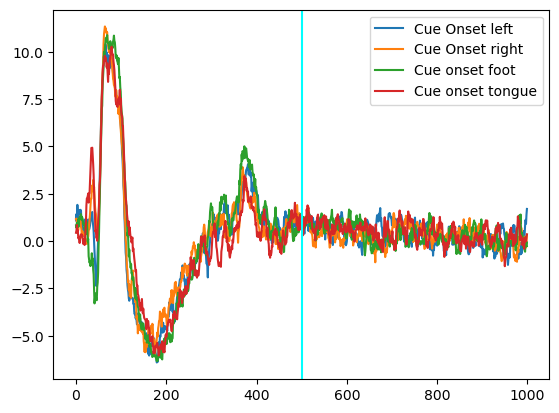

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,20,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,50:250]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,50:250]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


## Preprocessing the dataset

X_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
X_valid_prep = test_data_prep(x_valid) 
X_test_prep = test_data_prep(X_test) 

print('\n')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# # Adding width of the segment to be 1
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
# x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
# print('Shape of training set after adding width info:',x_train.shape)
# print('Shape of validation set after adding width info:',x_valid.shape)
# print('Shape of test set after adding width info:',x_test.shape)

print('\n')

# Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(X_train_prep, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(X_valid_prep, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(X_test_prep, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of X after trimming: (1615, 22, 200)
Shape of X after maxpooling: (1615, 22, 100)
Shape of X after averaging+noise and concatenating: (3230, 22, 100)
Shape of X after subsampling and concatenating: (6460, 22, 100)
Shape of Y: (6460,)
Shape of X after trimming: (500, 22, 200)
Shape of X after maxpooling: (500, 22, 100)
Shape of X after trimming: (443, 22, 200)
Shape of X after maxpooling: (443, 22, 100)


Shape of training labels after categorical conversion: (6460, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)


Shape of training set after dimension reshaping: (6460, 100, 22)
Shape of validation set after dimension reshaping: (500, 100, 22)
Shape of test set after dimension reshaping: (443, 100, 22)


In [24]:
# Building the CNN model using sequential class
rnn_clf = Sequential()

rnn_clf.add(LSTM(64, recurrent_dropout=0.1, input_shape=(100, 22), return_sequences=True,
                                             dropout=0.6, name="LSTM-1"))


rnn_clf.add(LSTM(32, recurrent_dropout=0.1, return_sequences=True,
                                             dropout=0.6))

rnn_clf.add(LSTM(16, recurrent_dropout=0.1, return_sequences=False,
                                             dropout=0.6))


rnn_clf.add(Dense(4, activation=nn.softmax, name="class-probs"))

# # Printing the model summary
rnn_clf.summary()








Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM-1 (LSTM)               (None, 100, 64)           22272     
                                                                 
 lstm_10 (LSTM)              (None, 100, 32)           12416     
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 class-probs (Dense)         (None, 4)                 68        
                                                                 
Total params: 37892 (148.02 KB)
Trainable params: 37892 (148.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

In [26]:
# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [27]:
# Compiling the model
rnn_clf.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
lstm_model_results = rnn_clf.fit(x_train,
             y_train,
             batch_size=256,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[early_stopping], verbose=True)




Epoch 1/100
26/26 [==============================] - 21s 457ms/step - loss: 1.3857 - accuracy: 0.2687 - val_loss: 1.3744 - val_accuracy: 0.3080
Epoch 2/100
26/26 [==============================] - 11s 438ms/step - loss: 1.3750 - accuracy: 0.2967 - val_loss: 1.3653 - val_accuracy: 0.2820
Epoch 3/100
26/26 [==============================] - 11s 427ms/step - loss: 1.3685 - accuracy: 0.3039 - val_loss: 1.3554 - val_accuracy: 0.3080
Epoch 4/100
26/26 [==============================] - 11s 431ms/step - loss: 1.3568 - accuracy: 0.3223 - val_loss: 1.3674 - val_accuracy: 0.3120
Epoch 5/100
26/26 [==============================] - 11s 424ms/step - loss: 1.3484 - accuracy: 0.3313 - val_loss: 1.3606 - val_accuracy: 0.3240
Epoch 6/100
26/26 [==============================] - 11s 432ms/step - loss: 1.3442 - accuracy: 0.3368 - val_loss: 1.3536 - val_accuracy: 0.3240
Epoch 7/100
26/26 [==============================] - 11s 430ms/step - loss: 1.3339 - accuracy: 0.3531 - val_loss: 1.3516 - val_accuracy:

In [ ]:
# Load the TensorBoard extension
# %tensorboard --logdir logs

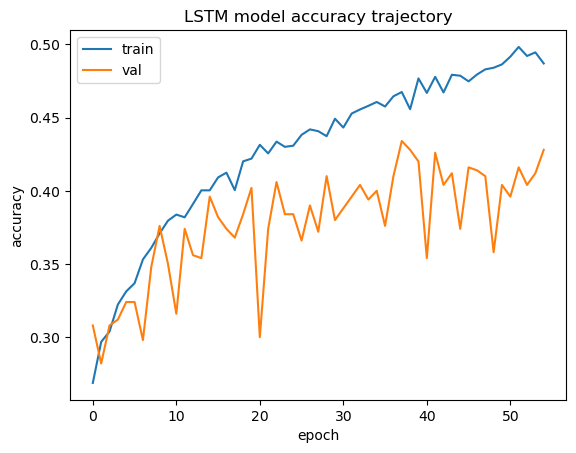

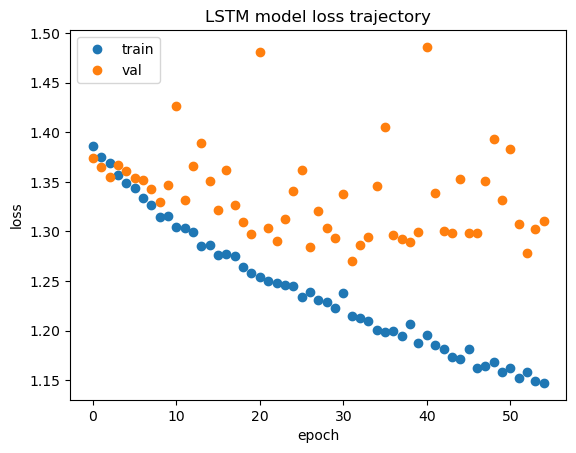

In [28]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(lstm_model_results.history['accuracy'])
plt.plot(lstm_model_results.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(lstm_model_results.history['loss'],'o')
plt.plot(lstm_model_results.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
## Testing the hybrid CNN-LSTM model

lstm_score = rnn_clf.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.3905192017555237
